In [1]:
import numpy as np

from ridge import (RidgeRegression,
                   make_regression_data,
                   plot_ridge_predictions,
                   add_multiplicitive_random_noise,
                   is_tail_point,
                   fit_preterbed_data_regression)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Adding Noise to Regression Predictors is Regularization

Ridge penalization is a popular and well studied method for reducing the varaince of predictions in regression.  There are many different yet equivelent ways to think about Ridge regression, some of the well known ones are:

  - A penalized optimization problem.
  - A constrained optimization problem.
  - A regression with an augmented data set.
  - A maximum a-postiori estimate in Bayesian linear regression.
  
In this post we will give another, less common, charactirization of ridge regression.

### Software

The code used to produce the simulations and plots in this post is available in [this git repository](https://github.com/madrury/ridge-regression-and-noisy-predictors).

### Acknowledgements

The idea for this post was inspired by a small section in the paper: [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

## Ridge Regression

Consider the usual linear regression setup.

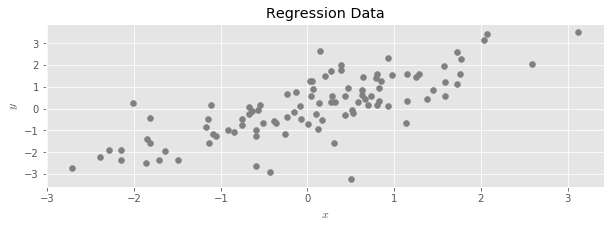

In [2]:
x, y = make_regression_data()

fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(x, y, color="grey")
ax.set_title("Regression Data")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

In **linear regression**, we seek a vector $\hat \beta$ which solves the following optimization problem:

$$ \hat \beta = argmin_\beta \left| y - X \beta \right|^2 $$

The goal of the problem is to produce a linear function that can be used to predict new values of $y$ when only provided with a values of $X$.  After solving the problem, these predicted values are given by

$$ \hat y = X \hat \beta $$

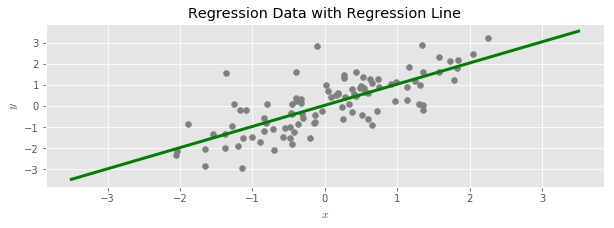

In [3]:
x, y = make_regression_data()

fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(x, y, color="grey")

r = RidgeRegression(lam=0.0).fit(x, y)
plot_ridge_predictions(ax, r, color="green", linewidth=3)

ax.set_title("Regression Data with Regression Line")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

**Ridge Regression** is an alternate way to estimate the regression line that is useful when linear regression produces predicted values with a high variance (for example, when there is not enough data available to estiamte effects for all of the avalable predictors).  This often has the desirable effect of improving the predictive power of the regression.

In the standard description, ridge regression is stated as a constrained optmization problem:

$$ \hat \beta = argmin_\beta \left| y - X \beta \right|^2 + \lambda \left| \beta \right|^2 $$

The parameter $\lambda$ controls the severity of the varaince reduction, larger values result in more biased but lower variance estimates.

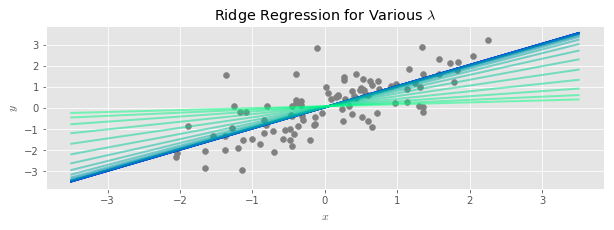

In [4]:
colors = plt.cm.winter(np.linspace(0, 1, 25))

fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(x, y, color="grey")
for lam, color in zip(np.logspace(-3, 3, num=25), colors):
    r = RidgeRegression(lam=lam).fit(x, y)
    plot_ridge_predictions(ax, r, color=color, alpha=0.5)
ax.set_title("Ridge Regression for Various $\lambda$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

## Adding Noise to Regression Predictors

In this post we will give an alternative description of ridge regression in terms of adding and then marginalizing over noise added to the data used to fit a regression.

Suppose we have available an unlimited number of independent and equally distributed Gaussian random varaibles:

$$ \epsilon_1, \epsilon_2, \ldots \sim Normal(1, \sigma) $$

If $X$ is a matrix containing the values of features in a regression problem, we say we have **added multiplicitive random noise to $X$** when we replace $X$ with a new dataset:

$$ e_{ij} \rightarrow \epsilon_{ij} x_{ij} $$

In words, we draw a random $Normal(1, \sigma)$ for every measurement in $X$, and multiply each data element by its corrosponding random number.

In [5]:
x_rand = add_multiplicitive_random_noise(x, sd=1.0)

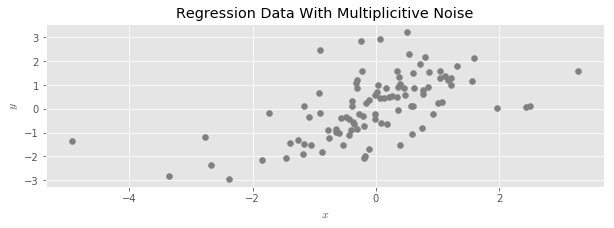

In [6]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(x_rand, y, color="grey")
ax.set_title("Regression Data With Multiplicitive Noise")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

To see the effect more clearly, let's color the upper and lower 10'th percentiles of the regression data set:

In [7]:
mask = is_tail_point(x)
color = np.array(["grey", "green"])[mask.astype(int)]

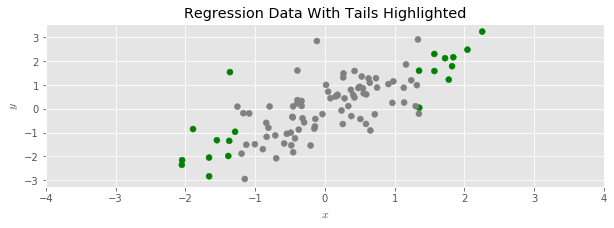

In [8]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(x, y, color=color)
ax.set_xlim(-4, 4)
ax.set_title("Regression Data With Tails Highlighted")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

And then disperse the data with multiplicitie random noise:

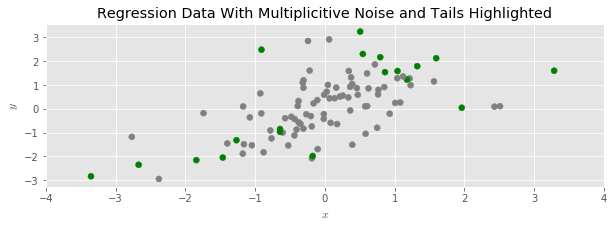

In [9]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(x_rand, y, color=color)
ax.set_xlim(-4, 4)
ax.set_title("Regression Data With Multiplicitive Noise and Tails Highlighted")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

We see that the data has spread out, and its range has expanded, as around half of the shaded points moved further away from the center of that point cloud.

Our idea is to fit a linear regression, but to the manipulated data.  Since the addition of the multiplicitive noise tends to spread the point cloud out, this depresses the slope of the regression line, exactly as in ridge regression.

In the plot below, the original data set is plotted in black, and the dispersed data we used to fit the regression line is plotted in light grey.

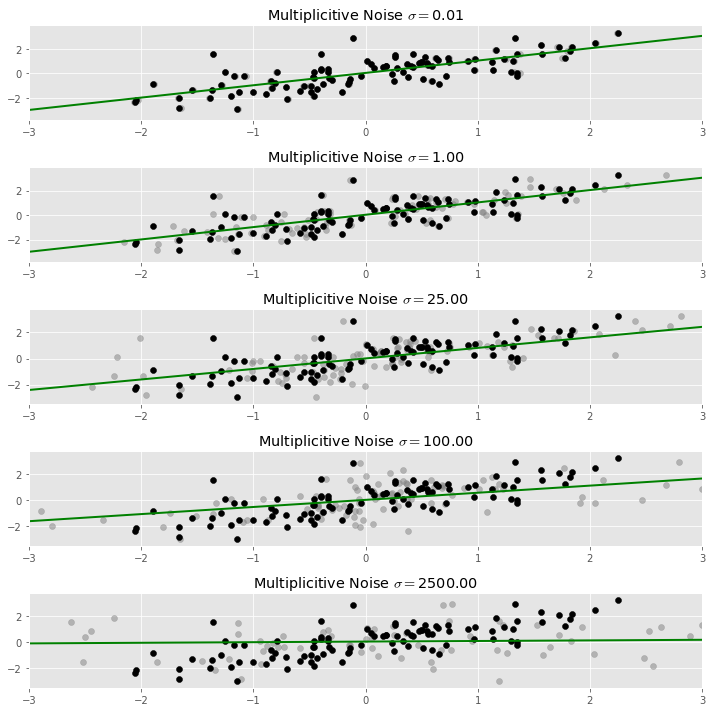

In [14]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

sds = [0.01, 0.1, 0.5, 1.0, 5.0]
for ax, sd in zip(axs, sds):
    x_preturbed = add_multiplicitive_random_noise(x, sd=sd)
    ax.scatter(x_preturbed, y, color="grey", alpha=0.5)
    
    ax.scatter(x, y, color="black", alpha=1.0)    

    r = RidgeRegression(lam=sd).fit(x_preturbed, y)
    plot_ridge_predictions(ax, r, color="green", linewidth=2)
    ax.set_title("Multiplicitive Noise $\sigma = ${:2.2f}".format(
        len(x)*sd**2, sd))
    ax.set_xlim(-3, 3)
    
fig.tight_layout()

Of course, when adding random noise to data, one expects to get a different result each time.  In our case, each time we fit a regression line to our noisy data, we expect to get a slightly different line.  To get a stable result out of this process, we need to *average together* all of out estimated regression lines.  This process is called *marginalization*, i.e., integrating out the randomness in the process.

Below we repreat the process of adding noise and fitting a regression many times, and plot each resulting regression line.  The result in a bundle of regression lines, which we can see fan out around an *average* line, which is the stable result of the process.

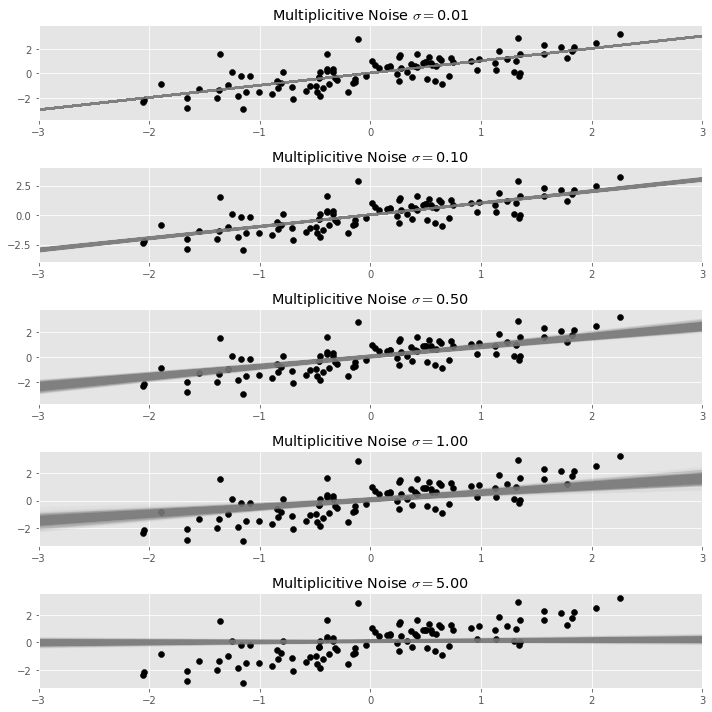

In [11]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
sds = [0.01, 0.1, 0.5, 1.0, 5.0]

for ax, sd in zip(axs, sds):
    #rigde_constant = 
    ax.scatter(x, y, color="black", alpha=1.0)
    for i in range(500):
        r_preterbed = fit_preterbed_data_regression(x, y, sd=sd)
        plot_ridge_predictions(ax, r_preterbed, color="grey", alpha=0.05)
    ax.set_title("Multiplicitive Noise $\sigma = ${:2.2f}".format(sd))
    ax.set_xlim(-3, 3)
    
fig.tight_layout()

We call this average line taken over many random dispersions of the same data set the **dispersed regression line with noise $\sigma$**.

The main conclusion of this post is that

> Suppose we are regressing against a data set containing $N$ observations.  Then the dispersed regression line with noise $\sigma$ is equal to the ridge regression line with penalty parameter $\lambda = N \sigma^2$.

This gives yet another characterization of ridge regression, it is a dispersed regression line with a properly chosen amount of multiplicitive noise $\sigma$.

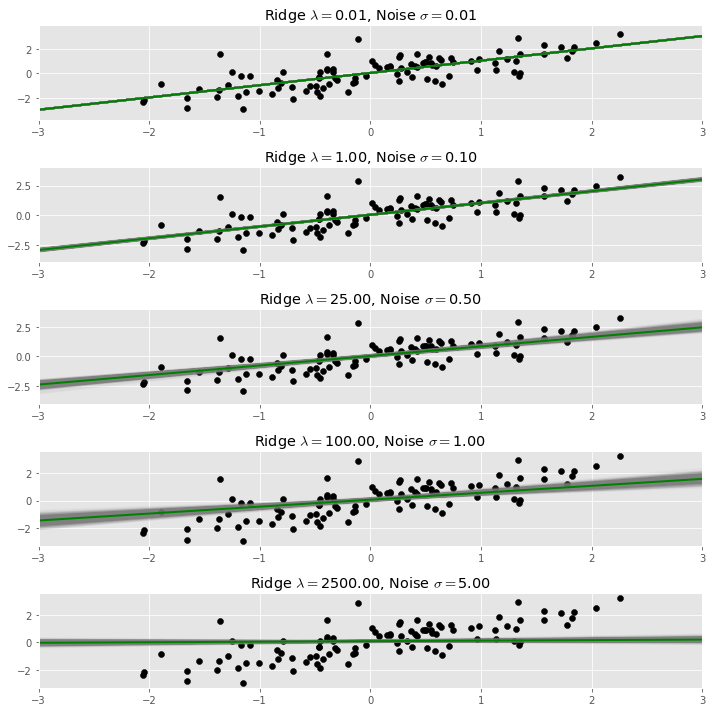

In [12]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
sds = [0.01, 0.1, 0.5, 1.0, 5.0]

for ax, sd in zip(axs, sds):
    #rigde_constant = 
    ax.scatter(x, y, color="black", alpha=1.0)
    for i in range(500):
        r_preterbed = fit_preterbed_data_regression(x, y, sd=sd)
        plot_ridge_predictions(ax, r_preterbed, color="grey", alpha=0.05)
    r = RidgeRegression(lam=len(x)*sd**2).fit(x, y)
    plot_ridge_predictions(ax, r, color="green", linewidth=2)
    ax.set_title("Ridge $\lambda = ${:4.2f}, Noise $\sigma = ${:2.2f}".format(
        len(x)*sd**2, sd))
    ax.set_xlim(-3, 3)
    
fig.tight_layout()

## Proof of The Claim

In this section we give the mathematical details of the demonstration that the two regression lines are equal.

### Statement of the Problem

In our setup, we scale each entry of $X$ by a small amount of gaussian noise before regressing:

$$ x_{ij} \rightarrow \epsilon_{ij} x_{ij} $$

where $\epsilon \sim N(1, \sigma)$.

Because we get a different line for each choice of random $\epsilon$; we are interested in what happens *on average*.  That is, we are interested in the solution vector $\beta$ that is the *expectation* under this process

$$ \hat \beta \sim argmin_\beta E_G \left[ \left| y - (G * X) \beta  \right|^2 \right] $$

In this equation, $G$ represents a matrix of random gaussian noise, the $*$ operator is elementwise multiplication of matricies, and $E_G$ marginalizes out the contributions of the noise.

Let's begin the demonstration by expanding out the quantity inside the expectation:

$$\begin{align*}
\left| y - (G * X) \beta  \right|^2 &= \left( y - (G * X) \beta \right)^t \left( y - (G * X) \beta \right) \\
&= y^t y - 2 y^t (G * X) \beta + \beta^t (G * X)^t (G * X) \beta
\end{align*}$$

### Computing the Quadratic Term

We focus on the last term for the moment. Let's name the random coeficient matrix $M$:

$$ M = (G * X)^t (G * X) $$

Now a single entry in this matrix is:

$$ m_{ij} = \sum_{k} \epsilon_{ki} \epsilon_{kj} x_{ki} x_{kj} $$

which in expectation is:

$$ E_G \left[ m_{ij} \right] = \sum_{k} E \left[ \epsilon_{ki} \epsilon_{kj} \right] x_{ki} x_{kj} $$

There are two cases here.  If $i \neq j$, then $\epsilon_{ki}$ and $\epsilon_{kj}$ are independent random varaibles both drawn from a $N(1, \sigma)$, so:

$$ E \left[ \epsilon_{ki} \epsilon_{kj} \right] = 1 \text{ for } i \neq j $$

When $i = j$, the $\epsilon$s are *not* independed, but we can compute:

$$ E \left[ \epsilon_{ki}^2 \right] = E \left[ (\epsilon_{ki} - 1)^2 + 2 \epsilon_{ki} - 1 \right] = \sigma^2 + 2 - 1 = \sigma^2 + 1 $$

So alltogether:

$$ E \left[ \epsilon_{ki} \epsilon_{kj} \right] = \begin{cases} \sigma^2 + 1 & \text{if} \ i = j \\ 1 & \text{otherwise} \end{cases} $$

This means that

$$ E[M] = \left( \mathbb{1} + diag(\sigma^2) \right) * X^t X  = X^t X + diag(\sigma^2) X^t X $$

Where $\mathbb{1}$ is a square matrix with a $1$ in every entry.

### Putting it All Together

Now we can compute the expectation of our entire quantity by applying the linearity of expectation, and using or previous calculation for the quadratic term:

$$\begin{align*}
E \left[ \left| y - (G * X) \beta  \right|^2 \right] &= E \left[ y^t y - 2 y^t (G * X) \beta + \beta^t (G * X)^t (G * X) \right] \\
&= y^t y - 2 y^t (E[G] * X) \beta + \beta^t E \left[ M \right] \beta \\
&= y^t y - 2 y^t X \beta + \beta^t X^t X \beta + \beta^t diag(\sigma^2) X^t X \beta \\
&= \left| y - X \beta \right|^2 + \beta^t diag(\sigma^2) X^t X \beta \\
&= \left| y - X \beta \right|^2 + \sigma^2 \left| \Gamma \beta \right|^2
\end{align*}$$

Where $\Gamma = \sqrt{ diag \left( X^t X \right) }$.

Overall, our original problem can be restated as

$$ \hat \beta \sim argmin_\beta \left( \left| y - X \beta \right|^2 + \sigma^2 \left| \Gamma \beta \right|^2 \right) $$

Which we recognise as linear regression with a [tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization) term, with the overall regularization strength depending on the amount of noise we add to each predictor: more noise results in stronger regularization.

### Ridge Regression

To make the connection to ridge regression, we recall that in ridge regression, we always ensure that our predictors are standardized before regressing.  That is, we ensure that $\frac{1}{N}diag(X^t X) = I$.

If we impose this assumption to our resulting regularization problem above , we get $\Gamma = NI$, and consequently:

$$ \hat \beta \sim argmin_\beta \left( \left| y - X \beta \right|^2 + N \sigma^2 \left|\beta \right|^2 \right) $$

So, under the usual assumptions of unit variance, our add-noise procedure is *in expectation* equivelent to ridge regression with a regularization strenght *equal* to $N \sigma^2$.